In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "data_exp1.json"

def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    return X, y


def prepare_datasets(test_size, validation_size):

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):

    # build network topology
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(3, activation='softmax'))

    return model


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.1, 0.1)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                        

In [2]:
def plot_accuracy(history):

    # create accuracy plot
    plt.figure(figsize=(5, 3))
    plt.plot(history.history["accuracy"], color = "b", label="train accuracy")
    plt.plot(history.history["val_accuracy"], color = "g", label="validation accuracy")
    plt.xlabel("Epoch", size=12)
    plt.ylabel("Accuracy", size=12)
    plt.legend(loc="lower right")
    plt.title("Training and Validation accuracy", size=14)
    plt.show()


def plot_error(history):

    # create error plot
    plt.figure(figsize=(5, 3))
    plt.plot(history.history["loss"], color = "b", label="train error")
    plt.plot(history.history["val_loss"], color = "g", label="validation error")
    plt.xlabel("Epoch", size=12)
    plt.ylabel("Loss", size=12)
    plt.legend(loc="upper right")
    plt.title("Training and Validation error", size=14)
    plt.show()

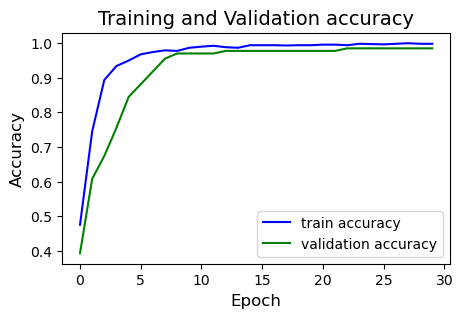

In [3]:
# plot accuracy
plot_accuracy(history)

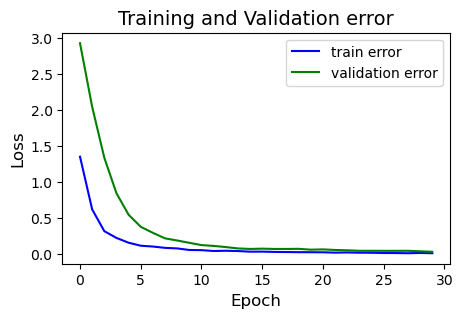

In [4]:
# plot error
plot_error(history)

In [5]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', test_acc)

5/5 [==============================] - 0s 12ms/step - loss: 0.0068 - accuracy: 1.0000

Test accuracy: 1.0


# Confusion Matrix

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

In [7]:
y_pred = model.predict(X_test).tolist()
y_pred = [y_pred[y_pred.index(i)].index(max(i)) for i in y_pred]

5/5 [==============================] - 0s 11ms/step


In [8]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[50,  0,  0],
       [ 0, 50,  0],
       [ 0,  0, 50]], dtype=int64)

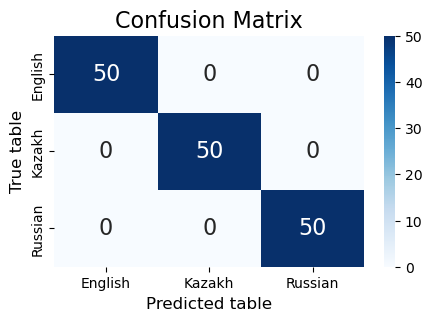

In [12]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(5, 3))
languages = ["English", "Kazakh", "Russian"]
cm_array_df = pd.DataFrame(cm, index=languages, columns=languages)
sn.heatmap(cm_array_df, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues) 
plt.title("Confusion Matrix", size=16)
plt.xlabel('Predicted table', size=12)
plt.ylabel('True table', size=12)
plt.show()